Решение системы линейных уравнений (n=12)
## Введение
Исследуем различные численные методы решения СЛАУ на примере матрицы $a_{ii}=1$, $a_{ij}=1/(i^2+j)$ при $i\\ne j$. Правые части $f_i=1/i$.
Исследуемые методы:
1. Гаусс с выбором главного элемента
2. LU-разложение
3. Якоби
4. Зейдель
5. SOR (верхняя релаксация)
6. Метод наискорейшего спуска
7. Метод минимальных невязок

## Методология

Во всех итерационных методах критерием остановки будем считать:

\begin{equation*}
\|r_k\|_2 = \|f - A x_k\|_2 \le \varepsilon,
\end{equation*}

где $\varepsilon$ — заданная точность.

## Исследование

Реализация всех методов решения:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy

In [2]:
"""
Input
"""

# II. 10.5 к)
def gen_matrix_k():
    n = 10
    A = []

    for i in range(n):
        arr = []
        for j in range(n):
            if i == j:
                arr.append(1)
            else:
                arr.append(1 / (i+1 + j+1))
        A.append(arr)

    F = [1/(i+1) for i in range(n)]

    return A, F

def gen_matrix_u():
    n = 12
    A = []

    for i in range(n):
        arr = []
        for j in range(n):
            if i == j:
                arr.append(1.0)
            else:
                arr.append(1.0 / ((i + 1) ** 2 + (j + 1)))
        A.append(arr)

    F = [1.0 / (i + 1) for i in range(n)]
    return A, F

A_k, F_k = gen_matrix_k()
A_u, F_u = gen_matrix_u()

In [9]:
"""
Test function
"""

def residual(A, F, x):
    n = len(A)
    s = 0.0
    for i in range(n):
        s += (sum([A[i][j] * x[j] for j in range(n)]) - F[i])**2
    return np.sqrt(s)

def print_result(A, F, x):
    print(f"Невязка ||Ax - F ||: {residual(A, F, x)}")

def print_matrix(M):
    n = len(M)

    for row in M:
        for elem in row:
            if elem is None:
                print(" None ", end="")
            else:
                print("%.3f " % elem, end="")
        print("")

    print("")

In [11]:
"""
Gauss
"""

def solve_gauss(A, F, eps=1e-15):
    assert len(A) == len(F)
    for i in A:
        assert len(i) == len(F)
    n = len(A)

    A = deepcopy(A)
    F = F.copy()

    # forward
    for i in range(n):
        pivot = i
        maxx = abs(A[i][i])
        for j in range(i+1, n):
            if abs(A[j][i]) > maxx:
                maxx = abs(A[j][i])
                pivot = j

        if maxx < eps:
            raise ValueError("Вырожденная система")

        if pivot != i:
            A[i], A[pivot] = A[pivot], A[i]
            F[i], F[pivot] = F[pivot], F[i]

        for j in range(i+1, n):
            c = A[j][i] / A[i][i]
            for k in range(n):
                A[j][k] -= A[i][k] * c
            F[j] -= F[i] * c

    x = [0 for _ in range(n)]

    # reverse
    for i in range(n-1, -1, -1):
        s = F[i]
        for j in range(i+1, n):
            s -= x[j]*A[i][j]
        x[i] = s / A[i][i]

    return x

print_result(A_k, F_k, solve_gauss(A_k, F_k))
print_result(A_u, F_u, solve_gauss(A_u, F_u))

Невязка ||Ax - F ||: 0.0
Невязка ||Ax - F ||: 7.343435057440258e-17


In [13]:
"""
LU
"""

def solve_LU(A, F, eps=1e-15):
    assert len(A) == len(F)
    for i in A:
        assert len(i) == len(F)
    n = len(A)

    A = deepcopy(A)
    F = F.copy()

    # Find L and U
    L = [[None for _ in range(n)] for _ in range(n)]
    U = [[None for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i > j:
                U[i][j] = 0
            elif i < j:
                L[i][j] = 0
            else:
                L[i][j] = 1

        for j in range(i, n):
            for k in range(i):
                A[i][j] -= L[i][k] * U[k][j]

            U[i][j] = A[i][j]

        for j in range(i+1, n):
            for k in range(i):
                A[j][i] -= L[j][k] * U[k][i]

            L[j][i] = A[j][i] / U[i][i]

    # Find answer
    v = [None]*n
    for i in range(n):
        v[i] = F[i]
        for j in range(i):
            v[i] -= L[i][j] * v[j]

    x = [None]*n
    for i in range(n-1, -1, -1):
        x[i] = v[i]
        for j in range(i+1, n):
            x[i] -= U[i][j] * x[j]
        x[i] /= U[i][i]

    return x

print_result(A_k, F_k, solve_LU(A_k, F_k))
print_result(A_u, F_u, solve_LU(A_u, F_u))

Невязка ||Ax - F ||: 0.0
Невязка ||Ax - F ||: 7.343435057440258e-17


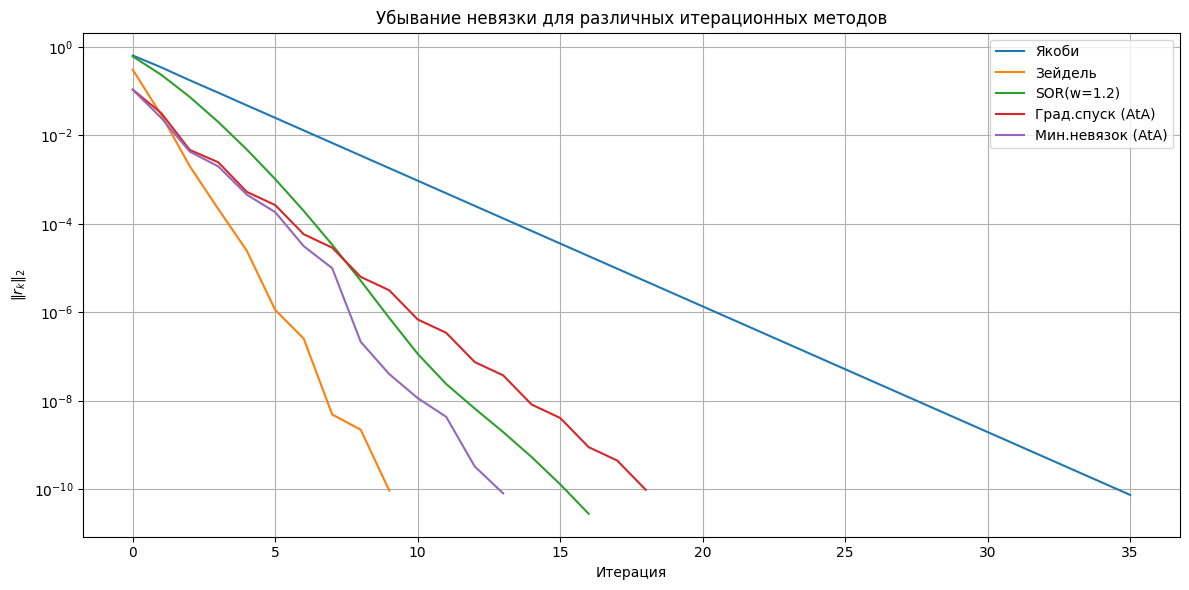

Итерационные методы: финальные невязки
Якоби:       7.516290845755113e-11
Зейдель:     9.427834814591582e-11
SOR (ω=1.2): 2.8113310293858257e-11
Град.спуск:  9.838333443899199e-11
Мин.невязок: 8.114673185645959e-11


In [28]:
"""
Jacobi
"""

def jacobi(A, F, tolerance=1e-10, max_iter=1000):
    n = len(F)
    x = [0]*n

    D = np.diag(A)
    if np.any(np.isclose(D, 0.0)):
        raise ValueError("Якоби неприменим для матриц с нулевыми диагональными элементами")

    residuals = []

    for k in range(max_iter):
        new_x = x[:]
        for i in range(n):
            s = 0
            for j in range(n):
                if i != j:
                    s += A[i][j] * x[j]
            new_x[i] = (F[i] - s) / A[i][i]

        x = new_x
        r = residual(A, F, x)
        residuals.append(r)
        if r < tolerance:
            break

    return x, residuals

"""
Seidel
"""

def seidel(A, F, tolerance=1e-10, max_iter=1000):
    n = len(F)
    x = [0]*n

    D = np.diag(A)
    if np.any(np.isclose(D, 0.0)):
        raise ValueError("Метод Зейделя неприменим для матриц с нулевыми диагональными элементами")

    residuals = []

    for k in range(max_iter):
        for i in range(n):
            s = 0
            for j in range(n):
                if i != j:
                    s += A[i][j] * x[j]
            x[i] = (F[i] - s) / A[i][i]

        r = residual(A, F, x)
        residuals.append(r)
        if r < tolerance:
            break

    return x, residuals

"""
SOR - succesive over-relaxation
"""

def sor(A, F, omega, tolerance=1e-10, max_iter=1000):
    n = len(F)
    x = [0]*n

    D = np.diag(A)
    if np.any(np.isclose(D, 0.0)):
        raise ValueError("Метод верхней релаксации неприменим для матриц с нулевыми диагональными элементами")

    residuals = []

    for k in range(max_iter):
        seidel_x = x[:]
        for i in range(n):
            s = 0
            for j in range(n):
                if i != j:
                    s += A[i][j] * seidel_x[j]
            seidel_x[i] = (F[i] - s) / A[i][i]
            x[i] = x[i] + omega * (seidel_x[i] - x[i])

        r = residual(A, F, x)
        residuals.append(r)
        if r < tolerance:
            break

    return x, residuals

"""
Mat * vec
"""

def mat_vec(A, x):
    res = [0]*len(A)
    for i in range(len(A)):
        for j in range(len(x)):
            res[i] += A[i][j] * x[j]

    return res

"""
Gradient descent (steepest)
"""

def steepest_descent(A, F, tolerance=1e-10, max_iter=1000):
    n = len(A)
    x = [0]*n
    residuals = []

    for k in range(max_iter):
        Ax = mat_vec(A, x)
        r = [Ax_ - F_ for (Ax_, F_) in zip(Ax, F)]

        Ar = mat_vec(A, r)
        denom = sum([r_ * Ar_ for (r_, Ar_) in zip(r, Ar)])

        tau = sum([r_**2 for r_ in r]) / denom

        for i in range(n):
            x[i] -= tau * r[i]

        res = residual(A, F, x)
        residuals.append(res)
        if res < tolerance:
            break

    return x, residuals

"""
Minimal residual
"""

def minimal_residual(A, F, tolerance=1e-10, max_iter=1000):
    n = len(A)
    x = [0]*n
    residuals = []

    for k in range(max_iter):
        Ax = mat_vec(A, x)
        r = [Ax_ - F_ for (Ax_, F_) in zip(Ax, F)]

        Ar = mat_vec(A, r)
        denom = sum([r_ * Ar_ for (r_, Ar_) in zip(r, Ar)])

        tau = denom / sum([Ar_**2 for Ar_ in Ar])

        for i in range(n):
            x[i] -= tau * r[i]

        res = residual(A, F, x)
        residuals.append(res)
        if res < tolerance:
            break

    return x, residuals

"""
Results
"""

def plot_residuals(histories, labels, title="Убывание невязки"):
    plt.figure(figsize=(12, 6))
    for res, label in zip(histories, labels):
        plt.semilogy(res, label=label)
    plt.xlabel("Итерация")
    plt.ylabel(r"$\|r_k\|_2$")
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

x_jacobi, res_jacobi = jacobi          (A_u, F_u)
x_gs,     res_gs     = seidel          (A_u, F_u)
x_sor,    res_sor    = sor             (A_u, F_u, omega=1.2)
x_gd,     res_gd     = steepest_descent(A_u, F_u)
x_mr,     res_mr     = minimal_residual(A_u, F_u)

histories = [res_jacobi, res_gs, res_sor, res_gd, res_mr]
labels = ["Якоби", "Зейдель", "SOR(w=1.2)",
          "Град.спуск", "Мин.невязок"]

plot_residuals(histories, labels,
               title="Убывание невязки для различных итерационных методов")

print("Итерационные методы: финальные невязки")
print("Якоби:      ", res_jacobi[-1])
print("Зейдель:    ", res_gs[-1])
print("SOR (ω=1.2):", res_sor[-1])
print("Град.спуск: ", res_gd[-1])
print("Мин.невязок:", res_mr[-1])